# Proximal Denoising

Pierre Boyeau

In [12]:
import numpy as np
import pywt
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from denoiser import Denoiser
import utils

We consider the following problem:
    
\begin{align*}
   \min_{x \in \mathcal{R}^N} \frac{1}{2}||x - y||^2 + f(Lx)
\end{align*}

The term $\frac{1}{2}||x - y||^2$ corresponds to a **data fidelity** term between $x$, the original image, and $y$ which is the image that we have at disposal on which Gaussian noise has been applied

$f(Lx)$ is a regularization term based on prior knowledge. $L$ will induce sparsity in the representation of $x$ in its wavelet transform.

\begin{align*}
   f(Lx) = \chi \sum_{j \in J} |(Lx)_j|^q, q \geq 1
\end{align*}

The choice of q is very important because it will influence the sparsity of our representation. 
$\chi$ is the regularization parameter, very difficult to tune in practice. The bigger $\chi$ the smaller weight we put on the data fidelity term, i.e. the bigger we regularize.

**Wavelets basics**:

\begin{align*}
   L^TL=LL^T=I \Rightarrow L^T=L^{-1}
\end{align*}

Starting point: wavelet modal function:

- Examples: Haar Transform, Debauchies $1, 2, 3 \dots$

Suppose $x$ is square of length $n$. Applying $L$ to $x$ will generate a object of the same size of $x$. Applying $L$ to $x$ will yield:

\begin{align*}
   \begin{pmatrix} \text{Approx terms} & \text{Horizontal terms}\\ \text{Vertical terms} & \text{Diagonal terms} \end{pmatrix}
\end{align*}

**Question 1**

Note that:

\begin{align*}
\min_{x \in \mathbb{R^N}} \frac{1}{2}||x - y||^2 + f(Lx)
\end{align*}

is strictly equal to $Prox_{f \circ L}(y)$

*Properties of $f\circ L$*

- $L$ is linear 
- $f$ is convex

Hence $f\circ L$ is convex

In addition $L$ is properly defined on $\mathbb{R}^N$, and since $f \in \Gamma_0(\mathbb{R})$, we conclude that $f \circ L$ is proper

Finally, $f$ being lsc and $L$ being continuous (finite dimension), we conclude by composition that $f\circ L$ is lsc

In conclusion, $f\circ L \in \Gamma_0(\mathbb{R})$

In our model, denoising the image is tantamount to computing the proximity operator of $f\circ L$

**Question 2**

We use the last property seen in class that allows to simplify the computation of the proximity operator for $f \circ L$, where we notice that L is a *tight operator* ($LL^* = \mu Id = Id$) and where $f\in\Gamma_0(\mathbb{R})$.

We get that:

\begin{align*}
    prox_{f\circ L}(y) &=& y - \mu^{-1}L^T \circ (Id - prox_f) \circ L(y) \\
    &=& y - L^T \circ (L(y) - prox_f L(x))
\end{align*}

Recall now that $L$ is an orthonormal transform. Hence $L^TL = Id$ and $L^T = L^{-1}$ and we get after simplifications that:


\begin{align*}
    prox_{f\circ L}(y) = L^T prox_f L(x) = L^{-1} prox_f L(x)
\end{align*}

**Question 3**

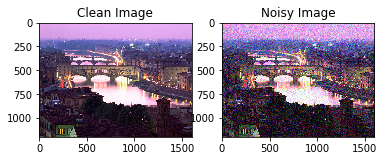

In [2]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

img = load_image('florence.jpg')

# Adding gaussian noise to the image
noisy_img = img + 30*np.random.normal(size=img.shape)
noisy_img = utils.clip(noisy_img)

fig, axes = plt.subplots(ncols=2)
plt.sca(axes[0])
plt.title('Clean Image')
plt.imshow(img)

plt.sca(axes[1])
plt.title('Noisy Image')
_ = plt.imshow(noisy_img)

**Question 4**

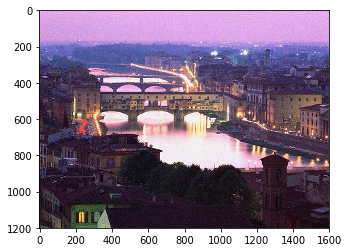

MSE:  193.94813038194445


In [57]:
WAVELET = 'db8'  #'haar'
LEVEL = 4  #1

# denoise = Denoiser(wavelet=WAVELET, level=LEVEL, q=1, chi=100.0)
denoise = Denoiser(wavelet='db9', level=2, q=1, chi=100.0)

my_cleaned_img = utils.clip(denoise.denoise(noisy_img))
plt.imshow(cleaned_img)
plt.show()

print('MSE: ', utils.mse(img, cleaned_img))

Let's now try to understand what is the influence of the different parameters of our model.

We "cheat" a bit and propose to find out which denoising parameters allow to get the best reconstruction by look a posteriori at the cleaned image and at its associated MSE with the original image.

**How to set these parameters?**

2 approaches can be followed. The first one consists in manually try to improve and understand the impact of the different choices made.

The other one consists in determining these parameters optimal value *via* grid search.

We propose first to try to understand the model assumptions consequences

# Manual setting of parameters for the Debauchies wavelet

**$\bullet$ Influence of chi**

As stated before, $\chi$ corresponds to the strengh of the regularization that will be applied to the image, as the following graph clearly shows.

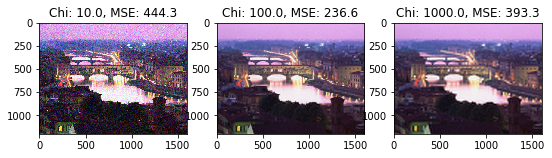

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 9))
for idx, chi_val in enumerate([10., 100., 1000.]):
    denoise = Denoiser(wavelet=WAVELET, level=LEVEL, q=1, chi=chi_val)
    cleaned_img = utils.clip(denoise.denoise(noisy_img))
    mse = utils.mse(img, cleaned_img)
    plt.sca(axes[idx])
    plt.title("Chi: {}, MSE: {}".format(chi_val, round(mse, 1)))
    plt.imshow(cleaned_img)

**$\bullet$ Level influence**


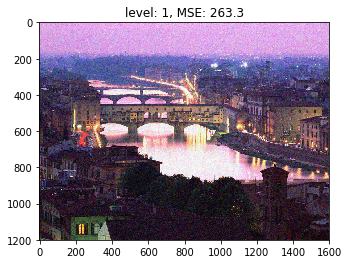

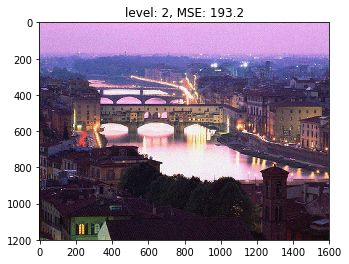

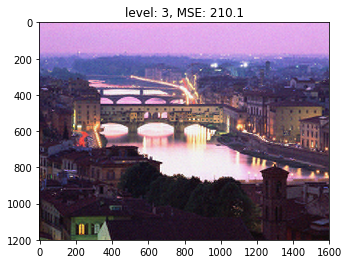

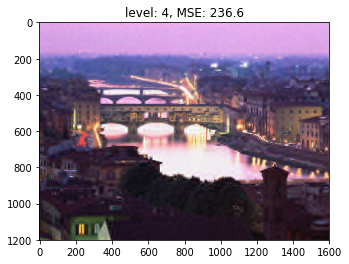

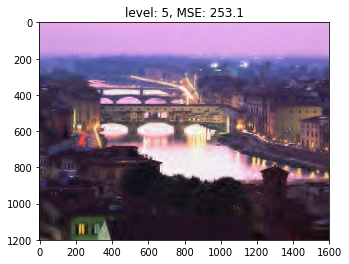

In [29]:
for idx, level in enumerate(range(1, 6)):
    denoise = Denoiser(wavelet=WAVELET, level=level, q=1, chi=100.0)
    cleaned_img = utils.clip(denoise.denoise(noisy_img))
    mse = utils.mse(img, cleaned_img)
    plt.figure()
    plt.title("level: {}, MSE: {}".format(level, round(mse, 1)))
    plt.imshow(cleaned_img)
    plt.show()

I do not have a lot of experience in wavelet theory, but from my understanding, the level will determine the maximum scale to which regularization will be applied.

Looking at above images shows that denoising for too low max level value won't clean the gaussian noise while too high level values will regularize textures that we would like to keep, creating the blur effect we can see in last images

**$\bullet$ Setting up $q$**

Recall that in our model, choosing $f$ is tantamount to bringing prior knowledge. We clearly see in below picture that the choice of the prior has a significant impact on performance

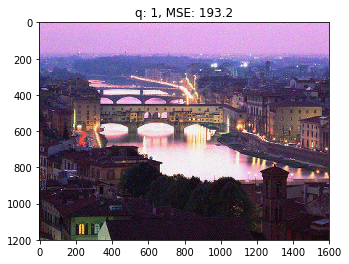

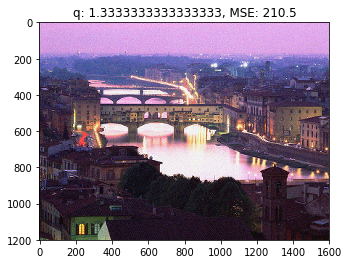

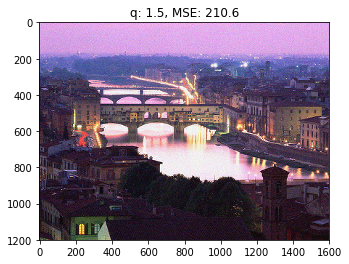

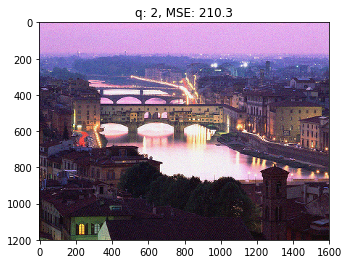

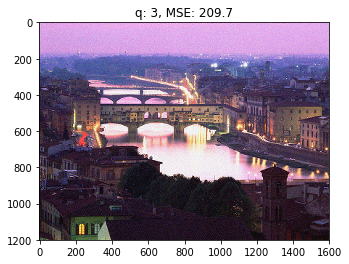

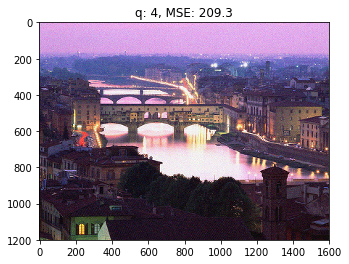

In [30]:
for idx, q in enumerate([1, 4/3, 3/2, 2, 3, 4]):
    denoise = Denoiser(wavelet=WAVELET, level=2, q=q, chi=100.0)
    cleaned_img = utils.clip(denoise.denoise(noisy_img))
    mse = utils.mse(img, cleaned_img)
    plt.figure()
    plt.title("q: {}, MSE: {}".format(q, round(mse, 1)))
    plt.imshow(cleaned_img)
    plt.show()

# Automatic choice of parameters for the *Haar* wavelets

Now that we have qualitatively interpreted each parameter of our model for a specific wavelet, we try to "beat" this first model with MSE $193.2$ by other models using other wavelets for instance.

To that purpose we use the following function, which simply select the best parameters out of a list of candidates. This of course is artificial, as in practise we do not have access to the original image

In [52]:
from sklearn.model_selection import ParameterGrid, ParameterSampler


def parameters_explorer(param_grid, n_iter=None):

    if n_iter is None:
        params_grid = list(ParameterGrid(param_grid))
    else:
        params_grid = list(ParameterSampler(param_grid, n_iter=n_iter))

    # Initialization
    params = params_grid[0]
    my_denoiser = Denoiser(**params)
    cleaned_img = utils.clip(my_denoiser.denoise(noisy_img))
    best_loss = utils.mse(img, cleaned_img)
    best_params = params
    best_img = cleaned_img
    
#     for params in tqdm(params_grid[1:]):
    for params in (params_grid[1:]):

        my_denoiser = Denoiser(**params)
        cleaned_img = utils.clip(my_denoiser.denoise(noisy_img))

        loss = utils.mse(img, cleaned_img)
        if loss < best_loss:
            best_loss = loss
            best_params = params
            best_img = cleaned_img

    return best_loss, best_params, cleaned_img

We focus on *haar* wavelets. *Debauchies* being more complex that *haar*, these 2 wavelets to have different properties and are susceptible to yield different results

In [53]:
params_grid = {
    "wavelet": ['haar'],
    "level": [1, 2, 3, 4, 5],
    "q": [1, 4/3, 3/2, 2, 3, 4],
    "chi": np.geomspace(start=10, stop=1000, num=10)
}

best_loss, best_params, best_img = parameters_explorer(params_grid, 
                                                       n_iter=100)

best parameters:  {'wavelet': 'haar', 'q': 1, 'level': 2, 'chi': 46.41588833612777}


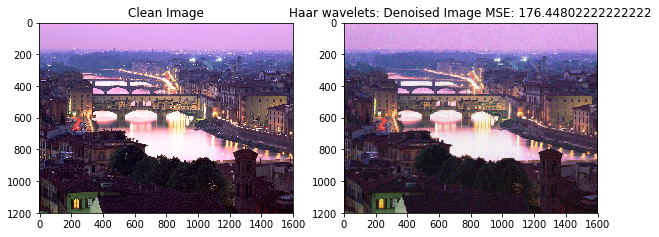

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
plt.sca(axes[0])
plt.title('Clean Image')
plt.imshow(img)
plt.sca(axes[1])
plt.title('Haar wavelets: Denoised Image MSE: {}'.format(best_loss))
plt.imshow(best_img)

print("best parameters: ", best_params)

best parameters:  {'wavelet': 'haar', 'q': 1, 'level': 2, 'chi': 46.41588833612777}


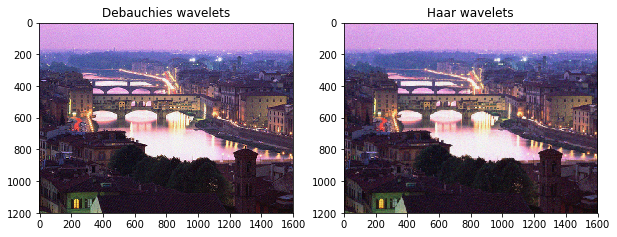

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
plt.sca(axes[0])
plt.title('Debauchies wavelets')
plt.imshow(my_cleaned_img)
plt.sca(axes[1])
plt.title('Haar wavelets'.format(best_loss))
plt.imshow(best_img)

print("best parameters: ", best_params)

In conclusion, the obtained denoised image using *haar* wavelets is also very good at denoising the image.
That being said, we can notice that the sky is still noisy, and I found in practice difficult to reduce this noise without loosing details in the foreground